In [277]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from skimage import data, color
from skimage.transform import resize

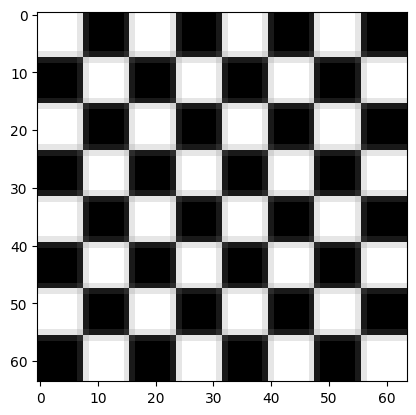

In [288]:
# Load and preprocess a grayscale image
image = data.checkerboard()
image = color.rgb2gray(image) if image.ndim != 2 else image
image = resize(image, (64, 64), anti_aliasing=True) if image.shape != (64, 64) else image
x0 = image.flatten()
plt.imshow(image, cmap='gray')

In [289]:
# Define the forward diffusion process parameters
T = 100  # number of timesteps
assert T >= 15 # Just for the sake of the example and images representation
betas = np.linspace(0.0001, 0.02, T)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)

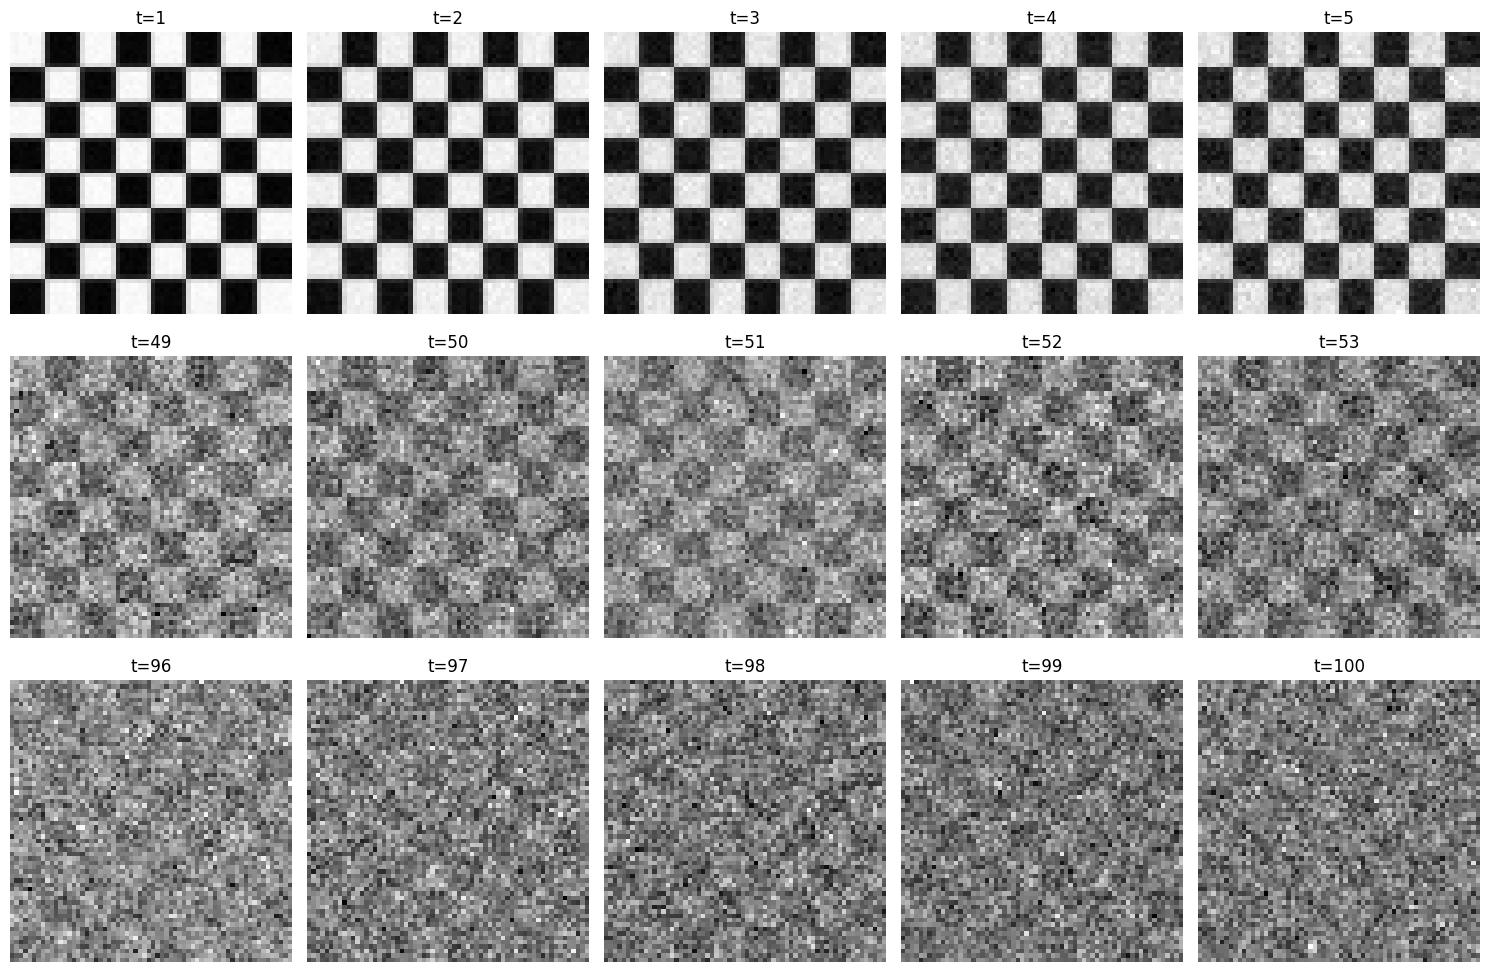

In [290]:
# Step 3: Generate degraded images at each step
degraded_images = []
for t in range(T):
    mean = np.sqrt(alpha_bars[t]) * x0
    var = 1 - alpha_bars[t]
    xt = mean + np.random.normal(0, np.sqrt(var), size=x0.shape)
    degraded_images.append(xt)

# Plot the first 5, middle 5, and last 5 degraded images
plt.figure(figsize=(15, 10))

# Plot first 5 images
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(degraded_images[i].reshape(64, 64), cmap='gray')
    plt.title(f"t={i+1}")
    plt.axis('off')

# Plot middle 5 images
middle_index = T // 2
for i in range(5):
    plt.subplot(3, 5, 6 + i)
    plt.imshow(degraded_images[middle_index - 2 + i].reshape(64, 64), cmap='gray')
    plt.title(f"t={middle_index - 2 + i + 1}")
    plt.axis('off')

# Plot last 5 images
for i in range(5):
    plt.subplot(3, 5, 11 + i)
    plt.imshow(degraded_images[T - 5 + i].reshape(64, 64), cmap='gray')
    plt.title(f"t={T - 5 + i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Diffusion Models: Forward and Reverse Processes

## Teoria

I modelli di diffusione costruiscono un processo markoviano per degradare progressivamente un'immagine $ x_0 $ aggiungendo rumore gaussiano, e successivamente imparano a invertire questo processo per generare o ricostruire immagini.

Il **forward process** viene definito come:
$$ q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I) $$

In pratica, a ogni step $ t $, l'immagine viene disturbata con una gaussiana a media dipendente da $ x_0 $ e varianza crescente.



Nel nostro studio, esaminiamo anche la **differenza tra due gaussiane consecutive**, ovvero:
$$ \frac{q(x_{t-1} \mid x_0)}{q(x_t \mid x_0)} \approx \mathcal{N}(\mu_r, \sigma_r^2) \quad where \quad  \mu_r = \sigma_r^2 \left( \frac{\mu_{t-1}}{\sigma_{t-1}^2} - \frac{\mu_t}{\sigma_t^2} \right), \quad \sigma_r^2 = \left( \frac{1}{\sigma_{t-1}^2} - \frac{1}{\sigma_t^2} \right)^{-1} $$

Questa formulazione ci permette di ricostruire immagini a partire da $ x_T $ tramite la "catena" delle gaussiane differenziali.


In [291]:
# Compute Gaussian ratio parameters using reversed ratio (q(x_{t-1}|x0)/q(x_t|x0))
from scipy.stats import multivariate_normal
mu_ratios = []
sigma_ratios = []
z_ratios = []
valid_steps = []

for t in range(1, T):
    alpha_bar_t = alpha_bars[t]
    alpha_bar_tm1 = alpha_bars[t - 1]

    sigma_t_sq = 1 - alpha_bar_t
    sigma_tm1_sq = 1 - alpha_bar_tm1

    inv_sigma_r_sq = (1 / sigma_tm1_sq) - (1 / sigma_t_sq)
    if inv_sigma_r_sq <= 0:
        print(f"Skipping invalid ratio at t={t}: inv_sigma_r_sq={inv_sigma_r_sq}")
        continue  # skip invalid 

    sigma_r_sq = 1 / inv_sigma_r_sq
    sigma_r = np.full_like(x0, sigma_r_sq) # np.full_like(x0, np.sqrt(sigma_r_sq)) #

    coef_tm1 = np.sqrt(alpha_bar_tm1) / sigma_tm1_sq
    coef_t = np.sqrt(alpha_bar_t) / sigma_t_sq
    mu_r = sigma_r_sq * (coef_tm1 - coef_t) * x0
    

    sigma_ratios.append(sigma_r)
    mu_ratios.append(mu_r)
    valid_steps.append(t)

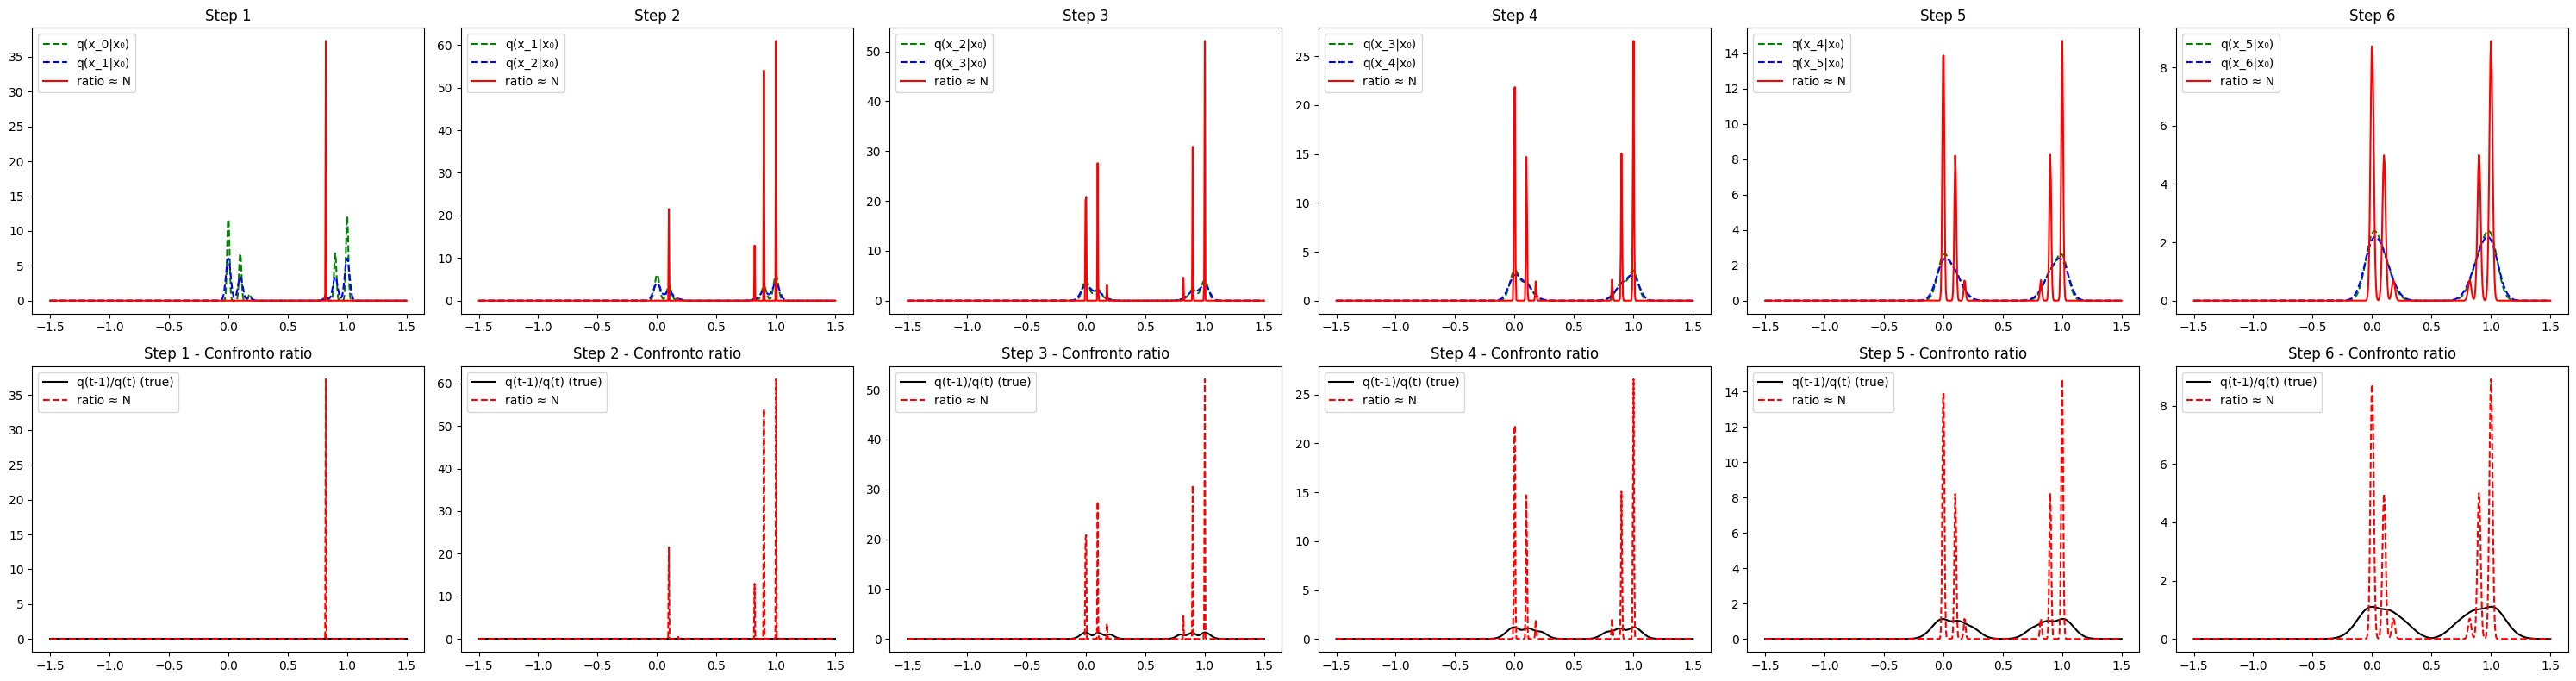

In [292]:
x_vals = np.linspace(-1.5, 1.5, 500)

# Find the first 6 valid steps (or fewer)
num_plots = min(6, len(valid_steps))
fig, axes = plt.subplots(2, num_plots, figsize=(5 * num_plots, 8))

for i in range(num_plots):
    t = valid_steps[i]
    
    # Calculate mu and sigma for the three Gaussians (q_t-1, q_t, ratio)
    mu_tm1 = np.sqrt(alpha_bars[t - 1]) * x0
    sigma_tm1 = np.sqrt(1 - alpha_bars[t - 1])
    
    mu_t = np.sqrt(alpha_bars[t]) * x0
    sigma_t = np.sqrt(1 - alpha_bars[t])
    
    mu_r = mu_ratios[i]
    sigma_r = sigma_ratios[i]
    
    # Calculate the PDF for the Gaussian distributions directly
    y_tm1 = norm.pdf(x_vals[:, None], mu_tm1, sigma_tm1)  # Broadcasting for all pixels
    y_t = norm.pdf(x_vals[:, None], mu_t, sigma_t)
    y_r = norm.pdf(x_vals[:, None], mu_r, sigma_r)

    ax = axes[0, i]
    ax.plot(x_vals, np.mean(y_tm1, axis=1), label=f"q(x_{t-1}|x₀)", color='green', linestyle='--')
    ax.plot(x_vals, np.mean(y_t, axis=1), label=f"q(x_{t}|x₀)", color='blue', linestyle='--')
    ax.plot(x_vals, np.mean(y_r, axis=1), label="ratio ≈ N", color='red')
    ax.set_title(f"Step {t}")
    ax.legend()

    # Plot the ratio (y_tm1 / y_t) vs y_r for comparison
    ax2 = axes[1, i]
    true_ratio = y_tm1.mean(axis=1) / y_t.mean(axis=1) if np.all(y_t.mean(axis=1) != 0) else np.zeros_like(y_tm1.mean(axis=1))
    ax2.plot(x_vals, true_ratio, label="q(t-1)/q(t) (true)", color='black')
    ax2.plot(x_vals, np.mean(y_r, axis=1), label="ratio ≈ N", color='red', linestyle='--')
    ax2.set_title(f"Step {t} - Confronto ratio")
    ax2.legend()

plt.tight_layout()
plt.show()

    


Reimplementiamo la ricostruzione backward partendo da x_T e usando le gaussiane ratio
La ricostruzione sarà fatta via "product of conditionals" partendo da x_T. Uniamo la ricostruzione deterministica e stocastica con confronto visivo

In [298]:
# Inizializzazione come rumore gaussiano completo
xT = np.random.normal(0, 1, size=x0.shape)
xt_reconstructed = xT.copy()
xt_stochastic = xT.copy()

reconstructed_steps = [xt_reconstructed.reshape(64, 64)]
stochastic_steps = [xt_stochastic.reshape(64, 64)]

# Applichiamo entrambe le ricostruzioni (deterministica e stocastica)
for i in reversed(range(len(valid_steps))):
    mu_r = mu_ratios[i]
    sigma_r = sigma_ratios[i]

    # Ricostruzione deterministica
    xt_reconstructed = mu_r + (xt_reconstructed - mu_r) * sigma_r
    reconstructed_steps.append(xt_reconstructed.reshape(64, 64))

    # Ricostruzione stocastica
    eps = np.random.normal(0, 1, size=mu_r.shape)
    xt_prev_stoch = mu_r + sigma_r * eps
    stochastic_steps.append(xt_prev_stoch.reshape(64, 64))
    xt_stochastic = xt_prev_stoch


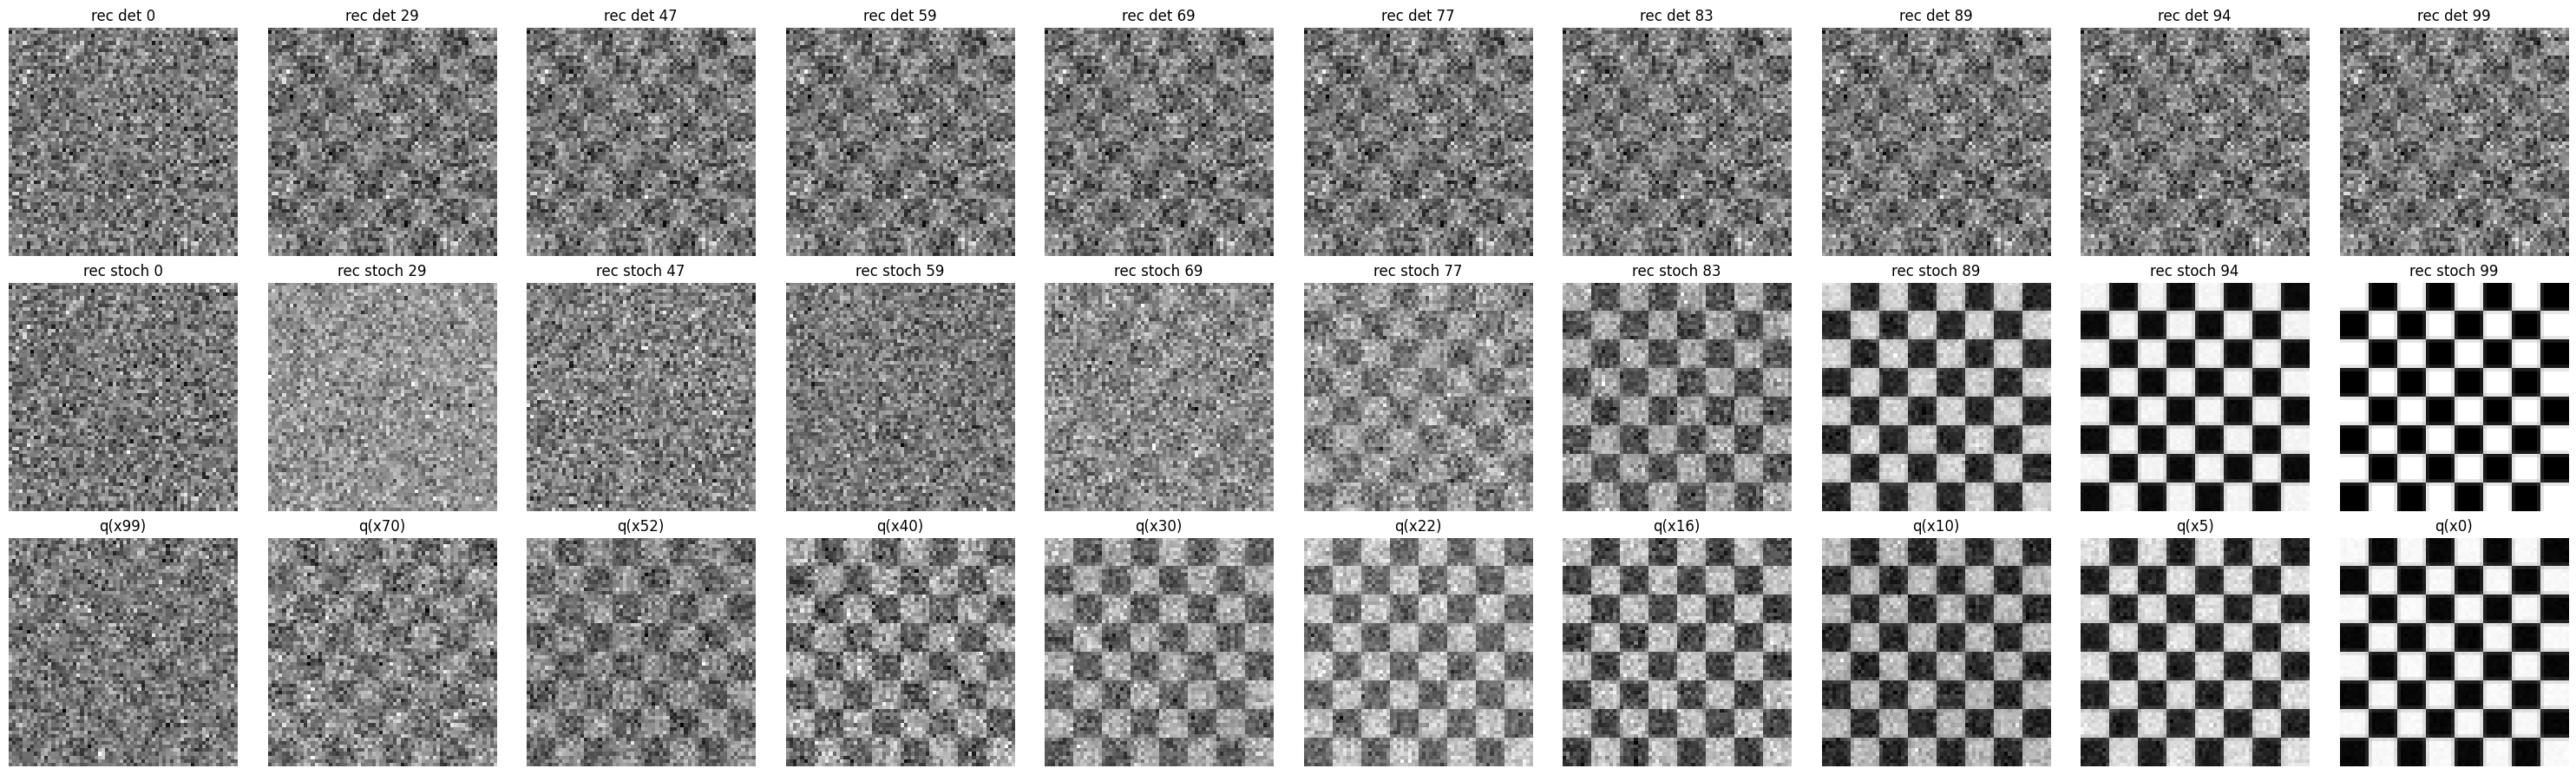

In [299]:

# Visualizzazione: 3 righe (rec deterministica, rec stocastica, degraded)
steps_to_show = min(len(degraded_images), 10)
fig, axes = plt.subplots(3, steps_to_show, figsize=(3 * steps_to_show, 9))

for i in range(steps_to_show):
    j = int(np.log1p(i) / np.log1p(steps_to_show - 1) * (len(degraded_images) - 1))

    # Plot 
    axes[0, i].imshow(reconstructed_steps[j], cmap='gray')
    axes[0, i].set_title(f"rec det {j}")
    axes[0, i].axis('off')

    axes[1, i].imshow(stochastic_steps[j], cmap='gray')
    axes[1, i].set_title(f"rec stoch {j}")
    axes[1, i].axis('off')

    axes[2, i].imshow(degraded_images[T - j - 1].reshape(64, 64), cmap='gray')
    axes[2, i].set_title(f"q(x{T - j - 1})")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()



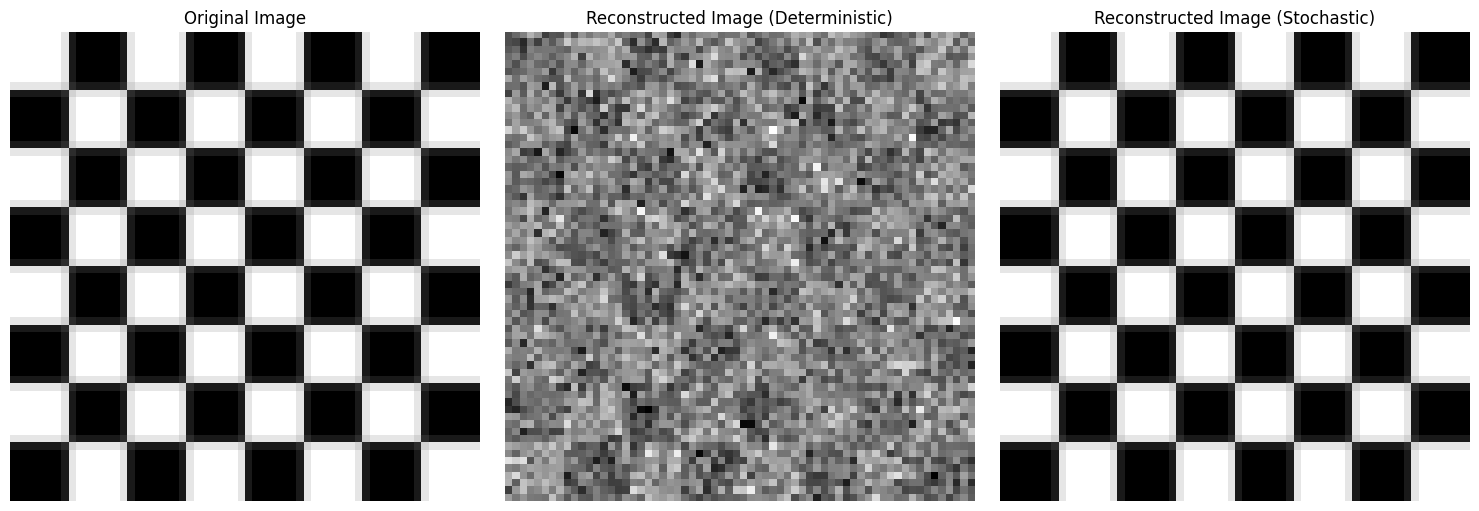

In [295]:

# Confronto finale tra le immagini ricostruite e l'immagine originale
plt.figure(figsize=(15, 5))  # Adjusted figure size for better layout
plt.subplot(1, 3, 1)  # Changed from 1 to 3
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)  # Changed from 2 to 3
plt.imshow(reconstructed_steps[-1], cmap='gray')
plt.title("Reconstructed Image (Deterministic)")
plt.axis('off')
plt.subplot(1, 3, 3)  # Updated to reflect the new layout
plt.imshow(stochastic_steps[-1], cmap='gray')
plt.title("Reconstructed Image (Stochastic)")
plt.axis('off')
plt.tight_layout()
plt.show()
